## Computational complexity (FLOPs) of algorithms, accuracy and energy consumption

Pytorch pre-trained models used for inference \
Energy consumption is measured using power monitor. \
10000 inferences on same image \
Code for running inference in <https://github.com/MScDisseration/model_hub/tree/master/Inference>

In order to get FLOP - used the pytorch module for profiling https://github.com/Lyken17/pytorch-OpCounter that returns the parameters and the MACs (multiply accumulate operation). \
MAC : a <- a + (b x c)
This module collects all the multiply operations and FLOPs is approximated to be double of MAC to account for other operations like add and divide. https://github.com/Lyken17/pytorch-OpCounter/tree/master/benchmark#macs-flops-what-is-the-difference  
Code in <https://github.com/MScDisseration/model_hub/blob/master/models.py>


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from scipy import stats
from sklearn import metrics

from matplotlib import cm
from adjustText import adjust_text
%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [2]:
url = 'logs/models.txt'
df = pd.read_csv(url)

In [3]:
df.describe()

,macs,parameters
count,3.500000e+01,3.500000e+01
mean,6.351510e+09,5.052139e+07
std,6.685961e+09,5.508621e+07
min,4.252426e+07,1.235496e+06
25%,5.659043e+08,5.332784e+06
50%,4.111515e+09,2.383457e+07
75%,1.133300e+10,1.078390e+08
max,2.279560e+10,1.436782e+08


In [4]:
df['FLOPS'] = df['macs'] * 2
df['GFLOPS'] = (df['macs'] * 2) / (10 ** 9) 
df['TFLOPS'] = (df['macs'] * 2) / (10 ** 12)
df['Params(Million)'] = df['parameters'] / (10 ** 6)
df['Log'] = np.log(df['FLOPS'])
df['GFLOPS_log'] = np.log(df['GFLOPS'])
df['Training 1 epoch(pfs-days)'] = df['GFLOPS'] * 2 * 3 * (1.2 * (10 ** 6))

In [5]:
print(df.GFLOPS.count())
df.head()

35


,model,macs,parameters,FLOPS,GFLOPS,TFLOPS,Params(Million),Log,GFLOPS_log,Training 1 epoch(pfs-days)
0,alexnet,7.146919e+08,61100840.0,1.429384e+09,1.429384,0.001429,61.100840,21.080509,0.357243,1.029156e+07
1,densenet121,2.865672e+09,7978856.0,5.731344e+09,5.731344,0.005731,7.978856,22.469216,1.745950,4.126568e+07
2,densenet161,7.787013e+09,28681000.0,1.557403e+10,15.574026,0.015574,28.681000,23.468870,2.745605,1.121330e+08
3,densenet169,3.398071e+09,14149480.0,6.796142e+09,6.796142,0.006796,14.149480,22.639621,1.916355,4.893222e+07
4,densenet201,4.340971e+09,20013928.0,8.681942e+09,8.681942,0.008682,20.013928,22.884511,2.161245,6.250998e+07


In [6]:
url = "logs/accuracy.csv" ##top 1 and top 5 error
df_accuracy = pd.read_csv(url)
print(df_accuracy.top1.count())

29


In [7]:
merge_df = df.merge(df_accuracy, on='model')

In [8]:
print(merge_df.top1.count())
merge_df.head()

29


,model,macs,parameters,FLOPS,GFLOPS,TFLOPS,Params(Million),Log,GFLOPS_log,Training 1 epoch(pfs-days),top1,top5
0,alexnet,7.146919e+08,61100840.0,1.429384e+09,1.429384,0.001429,61.100840,21.080509,0.357243,1.029156e+07,43.45,20.91
1,densenet121,2.865672e+09,7978856.0,5.731344e+09,5.731344,0.005731,7.978856,22.469216,1.745950,4.126568e+07,25.35,7.83
2,densenet161,7.787013e+09,28681000.0,1.557403e+10,15.574026,0.015574,28.681000,23.468870,2.745605,1.121330e+08,22.35,6.20
3,densenet169,3.398071e+09,14149480.0,6.796142e+09,6.796142,0.006796,14.149480,22.639621,1.916355,4.893222e+07,24.00,7.00
4,densenet201,4.340971e+09,20013928.0,8.681942e+09,8.681942,0.008682,20.013928,22.884511,2.161245,6.250998e+07,22.80,6.43


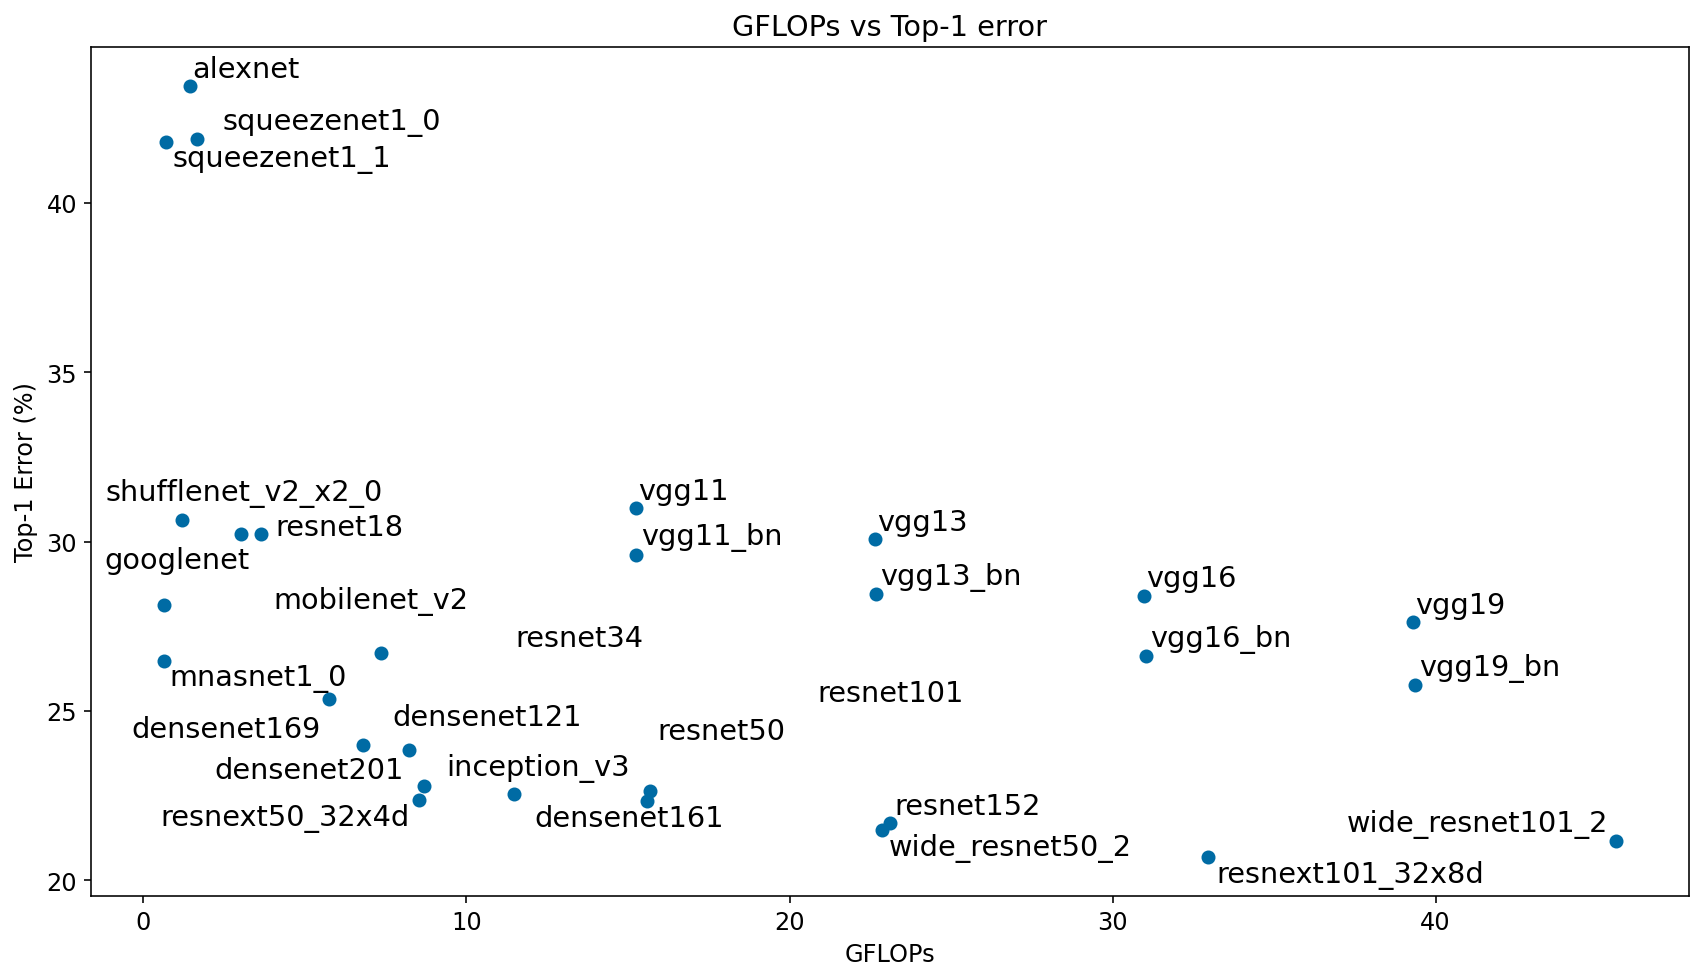

In [9]:
# needs citation https://github.com/Phlya/adjustText
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("GFLOPs")
ax.set_ylabel("Top-1 Error (%)")
ax.set_title("GFLOPs vs Top-1 error")

plt.scatter(merge_df['GFLOPS'], merge_df['top1'])

#merge_df[['GFLOPS','top1','model']].apply(lambda row: ax.text(*row),axis=1);
texts = [ax.text(x, y, name,size='large') 
         for x, y, name in zip(merge_df['GFLOPS'],merge_df['top1'],merge_df['model'])]

adjust_text(texts)
plt.tight_layout()
ax.figure.savefig('viz/top1error.png',dpi=300)

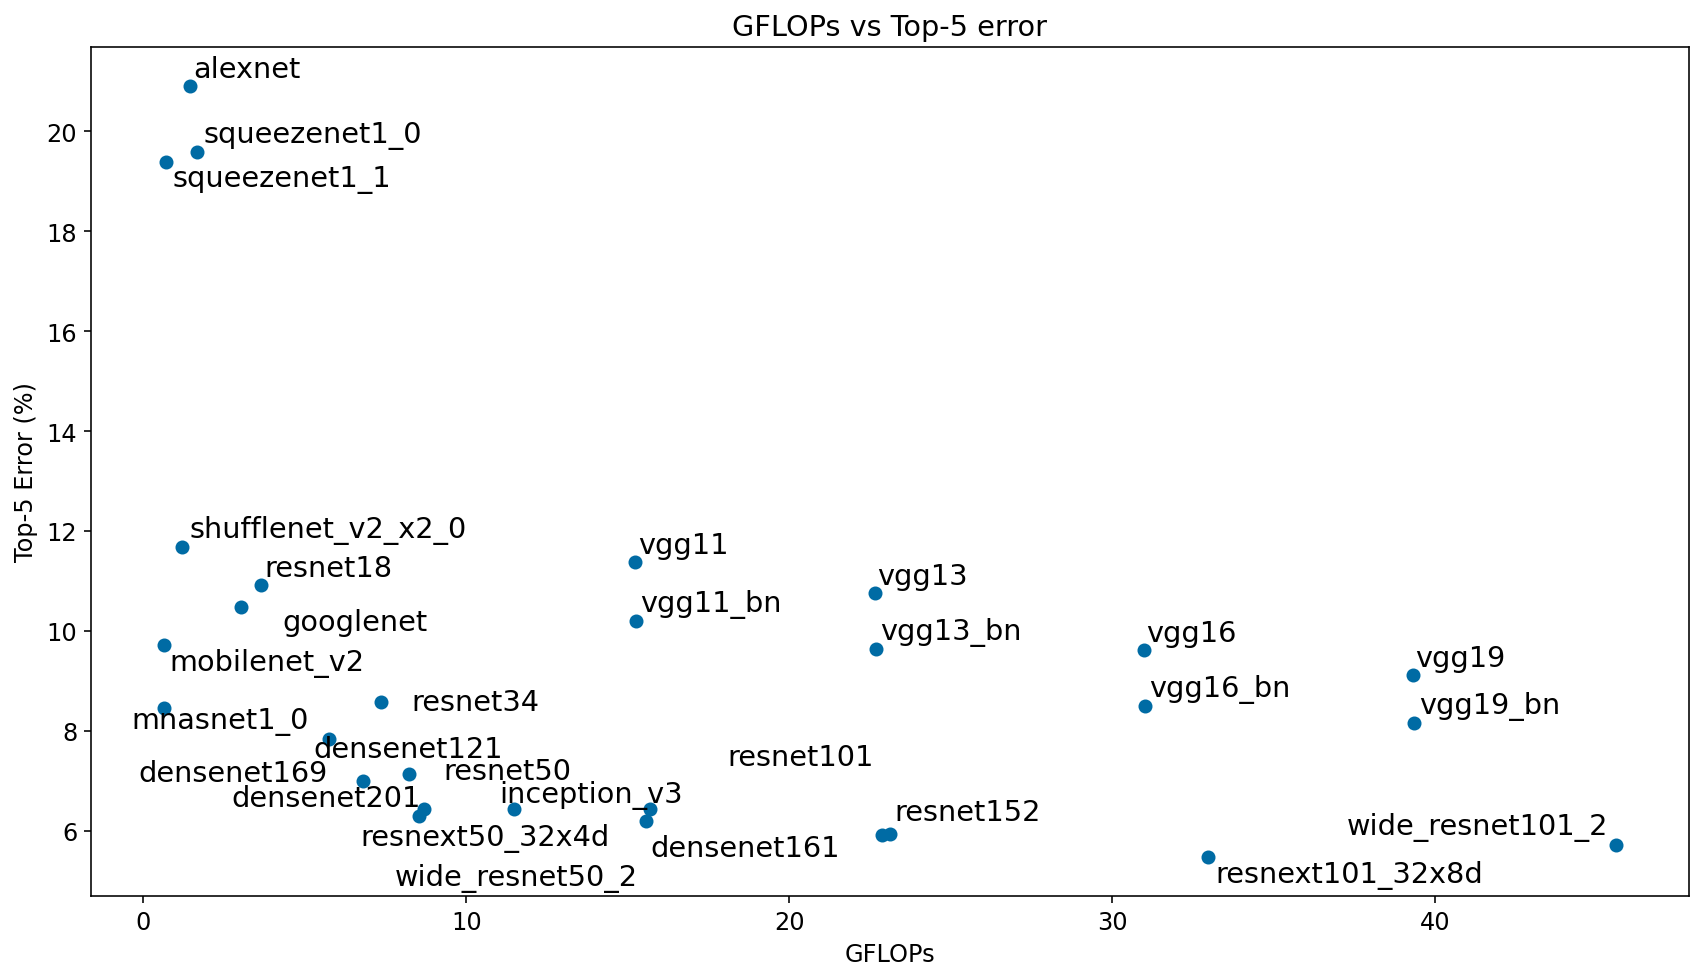

In [10]:
# needs citation https://github.com/Phlya/adjustText
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("GFLOPs")
ax.set_ylabel("Top-5 Error (%)")
ax.set_title("GFLOPs vs Top-5 error")
# cmap = cm.get_cmap('winter')
# c = merge_df['top5']
plt.scatter(merge_df['GFLOPS'], merge_df['top5'])

texts = [ax.text(x, y, name,size='large') 
         for x, y, name in zip(merge_df['GFLOPS'],merge_df['top5'],merge_df['model'])]
# cbar = plt.colorbar()
# cbar.set_label('Top-5 Error (%)')
adjust_text(texts)
plt.tight_layout()
ax.figure.savefig('viz/top5error.png',dpi=300)

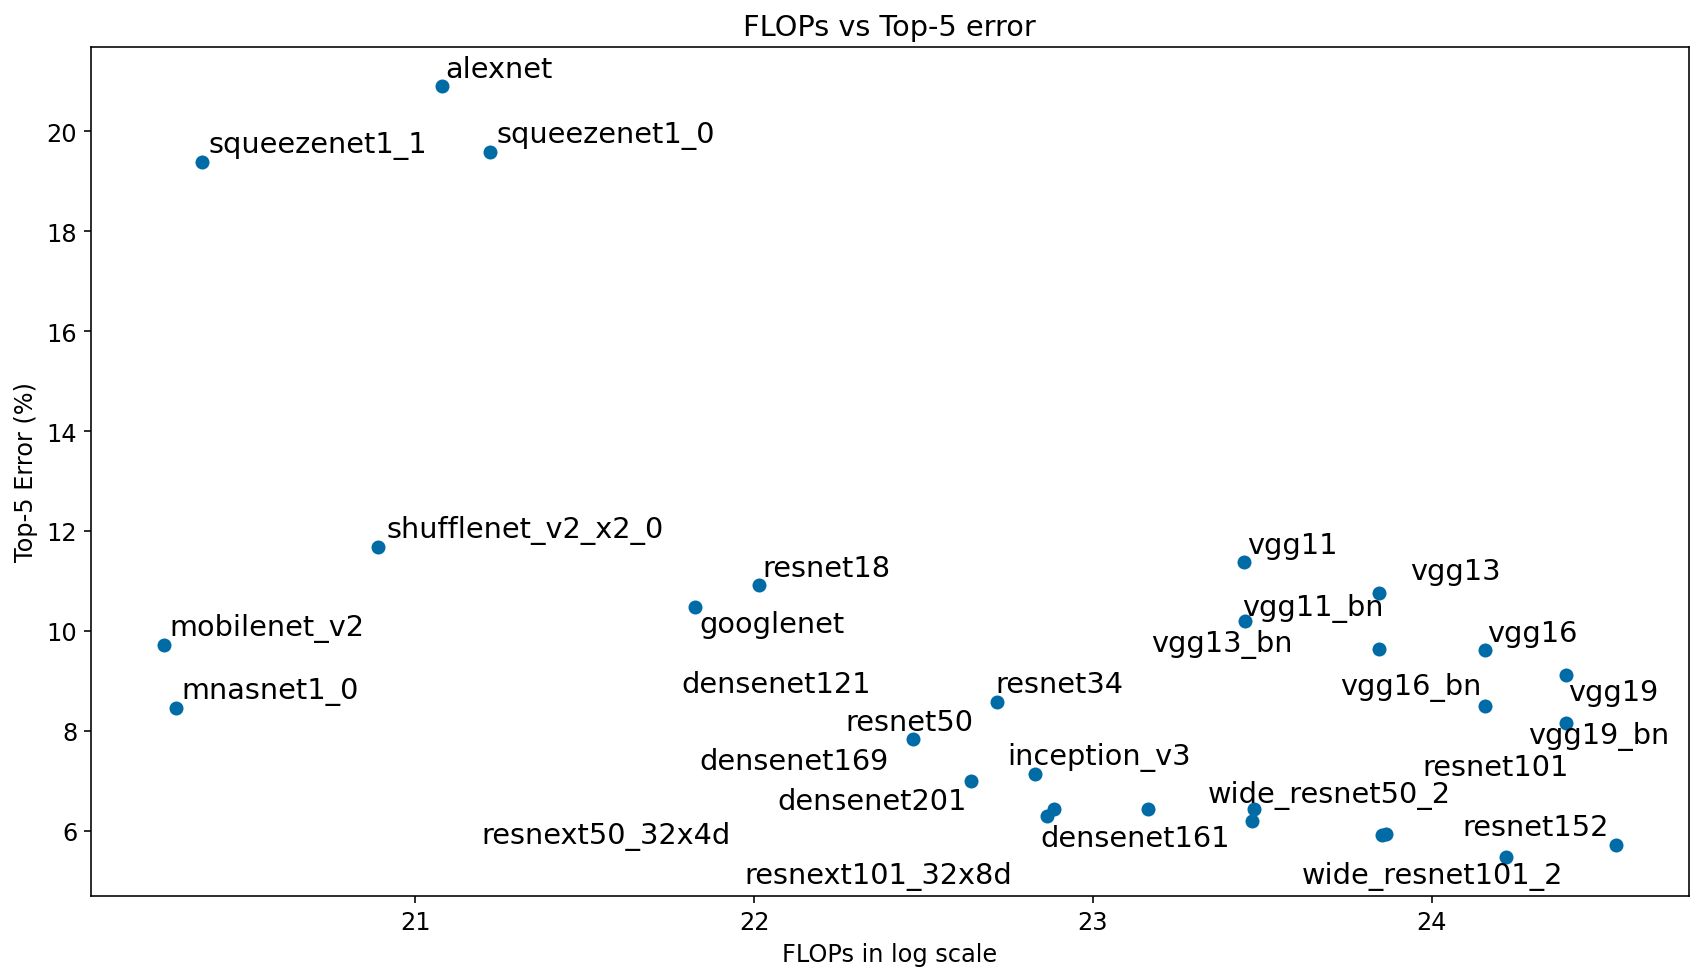

In [11]:
## in log scale
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("FLOPs in log scale")
ax.set_ylabel("Top-5 Error (%)")
ax.set_title("FLOPs vs Top-5 error")
# cmap = cm.get_cmap('winter')
# c = merge_df['top5']
plt.scatter(merge_df['Log'], merge_df['top5'])

texts = [ax.text(x, y, name,size='large') 
         for x, y, name in zip(merge_df['Log'],merge_df['top5'],merge_df['model'])]
# cbar = plt.colorbar()
# cbar.set_label('Top-5 Error (%)')
adjust_text(texts)
plt.tight_layout()
ax.figure.savefig('viz/logFLOPStop5error.png',dpi=300)

In [12]:
# cmap1= cm.get_cmap('winter')
# ax = merge_df.plot('GFLOPS', 'top5', kind='scatter',
#         c=range(len(merge_df)),colormap=cmap1, figsize=(12,7),
#                   title="GFLOPs vs Top-5 error")
# ax.set_xlabel("GFLOPs")
# ax.set_ylabel("Top-5 Error (%)")
# #merge_df[['GFLOPS','top5','model']].apply(lambda row: ax.text(*row),axis=1);
# texts = [ax.text(x, y, name,size='large') 
#          for x, y, name in zip(merge_df['GFLOPS'],merge_df['top5'],merge_df['model'])]
# adjust_text(texts)
# plt.tight_layout()
# ax.figure.savefig('viz/top5error.png',dpi=300)

In [43]:
x, y = merge_df['GFLOPS'],merge_df['top5'] 
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
print("R squared", r_value ** 2)
r,p = stats.pearsonr(x, y)
print(f"Pearson's coeff {r}\np-value {p}")

slope -0.13223517898807158 
intercept 11.457116334379469
r_value -0.43211360774286034
p_value 0.019237046397276903
std_err 0.053111265443602104
R squared 0.18672216999655056
Pearson's coeff -0.4321136077428604
p-value 0.019237046397276913


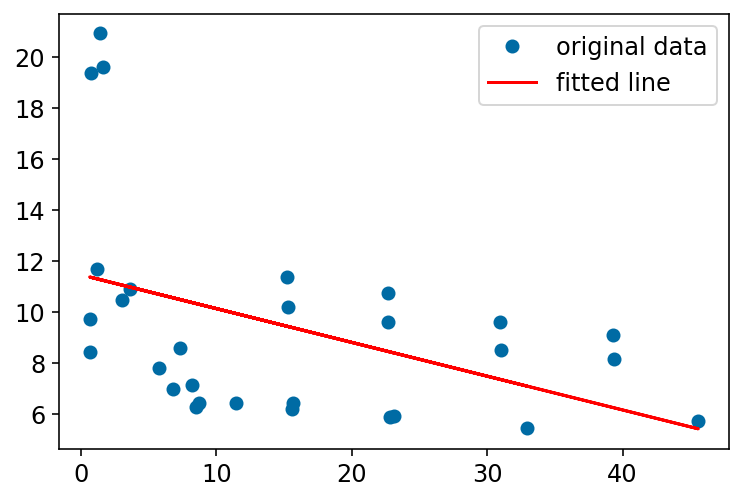

In [14]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

The complexity measured in FLOPs does not necessarily improve the accuracy (or decrease the error).

However, within the same architecture, e.g., VGG and resnet, the error decreases linearly with FLOPs

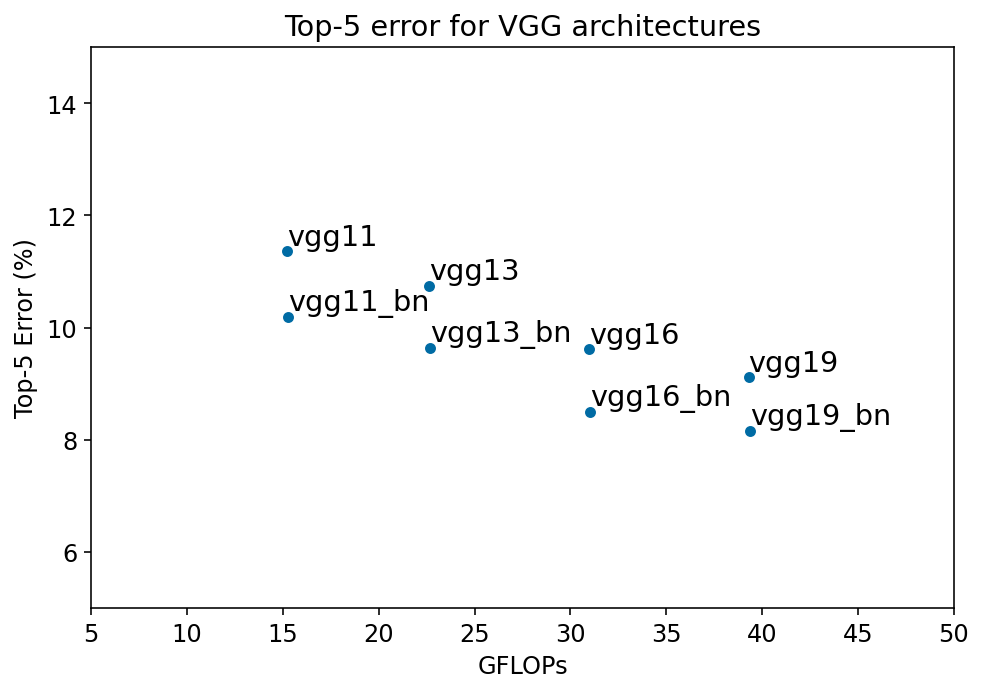

In [15]:
vggset = ['vgg11','vgg13','vgg16','vgg19','vgg11_bn','vgg13_bn','vgg16_bn','vgg19_bn']
vgg = merge_df.loc[merge_df.model.isin(vggset)]
ax = vgg.plot('GFLOPS', 'top5', kind='scatter',
         figsize=(7,5))
ax.set_xlim(5,50)
ax.set_ylim(5,15)
ax.set_xlabel("GFLOPs")
ax.set_ylabel("Top-5 Error (%)")
ax.set_title("Top-5 error for VGG architectures")
vgg[['GFLOPS','top5','model']].apply(lambda row: ax.text(*row,ha='left',va='bottom',size='large'),axis=1);
plt.tight_layout()
ax.figure.savefig("viz/vggtop5error.png",dpi=300)

In [16]:
x, y = vgg['GFLOPS'],vgg['top5'] 
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
print("R squared", r_value ** 2)

slope -0.0940566389469843 
intercept 12.211244926500065
r_value -0.8313541476640571
p_value 0.010525762985377246
std_err 0.025668575213328274
R squared 0.691149718838231


## Power monitor readings

In [17]:
df_reading = pd.read_csv("logs/power_reading_2.csv")

In [18]:
df_reading['last_changed'] = pd.to_datetime(df_reading['last_changed'], errors='coerce')
df_reading.dropna(subset=['last_changed'], inplace=True)
df_reading.set_index('last_changed', inplace=True)

In [19]:
df_reading.tail()

,entity_id,node_id,power_consumption,unit
last_changed,,,,
2020-08-07 18:30:59.184643+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,81.537,W
2020-08-07 18:31:02.186485+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,80.685,W
2020-08-07 18:31:05.183236+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,82.364,W
2020-08-07 18:31:08.185608+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,80.557,W
2020-08-07 18:31:11.182838+00:00,sensor.aeon_labs_zw096_smart_switch_6_power_2,5.0,82.175,W


In [20]:
# time intervals
df_time_interval = pd.read_csv("logs/pm.csv")

In [21]:
print(df_time_interval.model.count())
df_time_interval.head()

30


,model,start_time,end_time
0,alexnet,2020-08-07 15:46:21.270897,2020-08-07 15:50:52.335178
1,densenet121,2020-08-07 15:50:52.537935,2020-08-07 15:58:07.359863
2,densenet161,2020-08-07 15:58:08.019219,2020-08-07 16:06:24.882168
3,densenet169,2020-08-07 16:06:25.350567,2020-08-07 16:14:50.802017
4,densenet201,2020-08-07 16:14:51.393209,2020-08-07 16:24:11.209650


In [22]:
df_time_interval['start_seconds']= [datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
                                  for start_time in df_time_interval.start_time]
df_time_interval['end_seconds'] = [datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
                                for end_time in df_time_interval.end_time]
df_time_interval['total_time'] = df_time_interval['end_seconds'] - df_time_interval['start_seconds']
df_time_interval['total_time'] = df_time_interval['total_time'].apply(lambda x: x.total_seconds())
df_time_interval.head()

,model,start_time,end_time,start_seconds,end_seconds,total_time
0,alexnet,2020-08-07 15:46:21.270897,2020-08-07 15:50:52.335178,2020-08-07 14:46:21.270897,2020-08-07 14:50:52.335178,271.064281
1,densenet121,2020-08-07 15:50:52.537935,2020-08-07 15:58:07.359863,2020-08-07 14:50:52.537935,2020-08-07 14:58:07.359863,434.821928
2,densenet161,2020-08-07 15:58:08.019219,2020-08-07 16:06:24.882168,2020-08-07 14:58:08.019219,2020-08-07 15:06:24.882168,496.862949
3,densenet169,2020-08-07 16:06:25.350567,2020-08-07 16:14:50.802017,2020-08-07 15:06:25.350567,2020-08-07 15:14:50.802017,505.451450
4,densenet201,2020-08-07 16:14:51.393209,2020-08-07 16:24:11.209650,2020-08-07 15:14:51.393209,2020-08-07 15:24:11.209650,559.816441


In [23]:
df_time_interval['s_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["start_seconds"]]
df_time_interval['e_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["end_seconds"]]
df_time_interval['s_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["start_seconds"]]
df_time_interval['e_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["end_seconds"]]
df_time_interval.head()

,model,start_time,end_time,start_seconds,end_seconds,total_time,s_date,e_date,s_time,e_time
0,alexnet,2020-08-07 15:46:21.270897,2020-08-07 15:50:52.335178,2020-08-07 14:46:21.270897,2020-08-07 14:50:52.335178,271.064281,2020-08-07,2020-08-07,14:46:21,14:50:52
1,densenet121,2020-08-07 15:50:52.537935,2020-08-07 15:58:07.359863,2020-08-07 14:50:52.537935,2020-08-07 14:58:07.359863,434.821928,2020-08-07,2020-08-07,14:50:52,14:58:07
2,densenet161,2020-08-07 15:58:08.019219,2020-08-07 16:06:24.882168,2020-08-07 14:58:08.019219,2020-08-07 15:06:24.882168,496.862949,2020-08-07,2020-08-07,14:58:08,15:06:24
3,densenet169,2020-08-07 16:06:25.350567,2020-08-07 16:14:50.802017,2020-08-07 15:06:25.350567,2020-08-07 15:14:50.802017,505.451450,2020-08-07,2020-08-07,15:06:25,15:14:50
4,densenet201,2020-08-07 16:14:51.393209,2020-08-07 16:24:11.209650,2020-08-07 15:14:51.393209,2020-08-07 15:24:11.209650,559.816441,2020-08-07,2020-08-07,15:14:51,15:24:11


In [24]:
# not used
# def power_mean(s_date,e_date,s_time,e_time):
#     subset_df = df_reading.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
#     return subset_df['power_consumption'].mean()


In [25]:
# get total power consumed 
# since power monitor reads at intervals of 3 seconds hence multiplying by 3
def energy_consumption(s_date,e_date,s_time,e_time):
    subset_df = df_reading.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
    return ((subset_df['power_consumption']).sum() * 3) #Joules 

In [26]:
for index, row in df_time_interval.iterrows(): 
    df_time_interval.at[index,'empirical'] = energy_consumption(row['s_date'],row['e_date'],
                                            row['s_time'],row['e_time'])

In [27]:
# for index, row in df_time_interval.iterrows(): 
#     df_time_interval.at[index,'mean_power'] = power_mean(row['s_date'],row['e_date'],
#                                             row['s_time'],row['e_time'])

In [28]:
# df_time_interval['power'] = df_time_interval['mean_power'] * df_time_interval['total_time']
df_time_interval.head()

,model,start_time,end_time,start_seconds,end_seconds,total_time,s_date,e_date,s_time,e_time,empirical
0,alexnet,2020-08-07 15:46:21.270897,2020-08-07 15:50:52.335178,2020-08-07 14:46:21.270897,2020-08-07 14:50:52.335178,271.064281,2020-08-07,2020-08-07,14:46:21,14:50:52,49286.160
1,densenet121,2020-08-07 15:50:52.537935,2020-08-07 15:58:07.359863,2020-08-07 14:50:52.537935,2020-08-07 14:58:07.359863,434.821928,2020-08-07,2020-08-07,14:50:52,14:58:07,78023.316
2,densenet161,2020-08-07 15:58:08.019219,2020-08-07 16:06:24.882168,2020-08-07 14:58:08.019219,2020-08-07 15:06:24.882168,496.862949,2020-08-07,2020-08-07,14:58:08,15:06:24,107728.158
3,densenet169,2020-08-07 16:06:25.350567,2020-08-07 16:14:50.802017,2020-08-07 15:06:25.350567,2020-08-07 15:14:50.802017,505.451450,2020-08-07,2020-08-07,15:06:25,15:14:50,93777.609
4,densenet201,2020-08-07 16:14:51.393209,2020-08-07 16:24:11.209650,2020-08-07 15:14:51.393209,2020-08-07 15:24:11.209650,559.816441,2020-08-07,2020-08-07,15:14:51,15:24:11,107143.290


In [29]:
new_df = df_time_interval.merge(merge_df, on='model')
new_df.model.count()

27

In [30]:
new_df['empirical'] = new_df['empirical'] / (1000 * 3600) # Joules to kWh

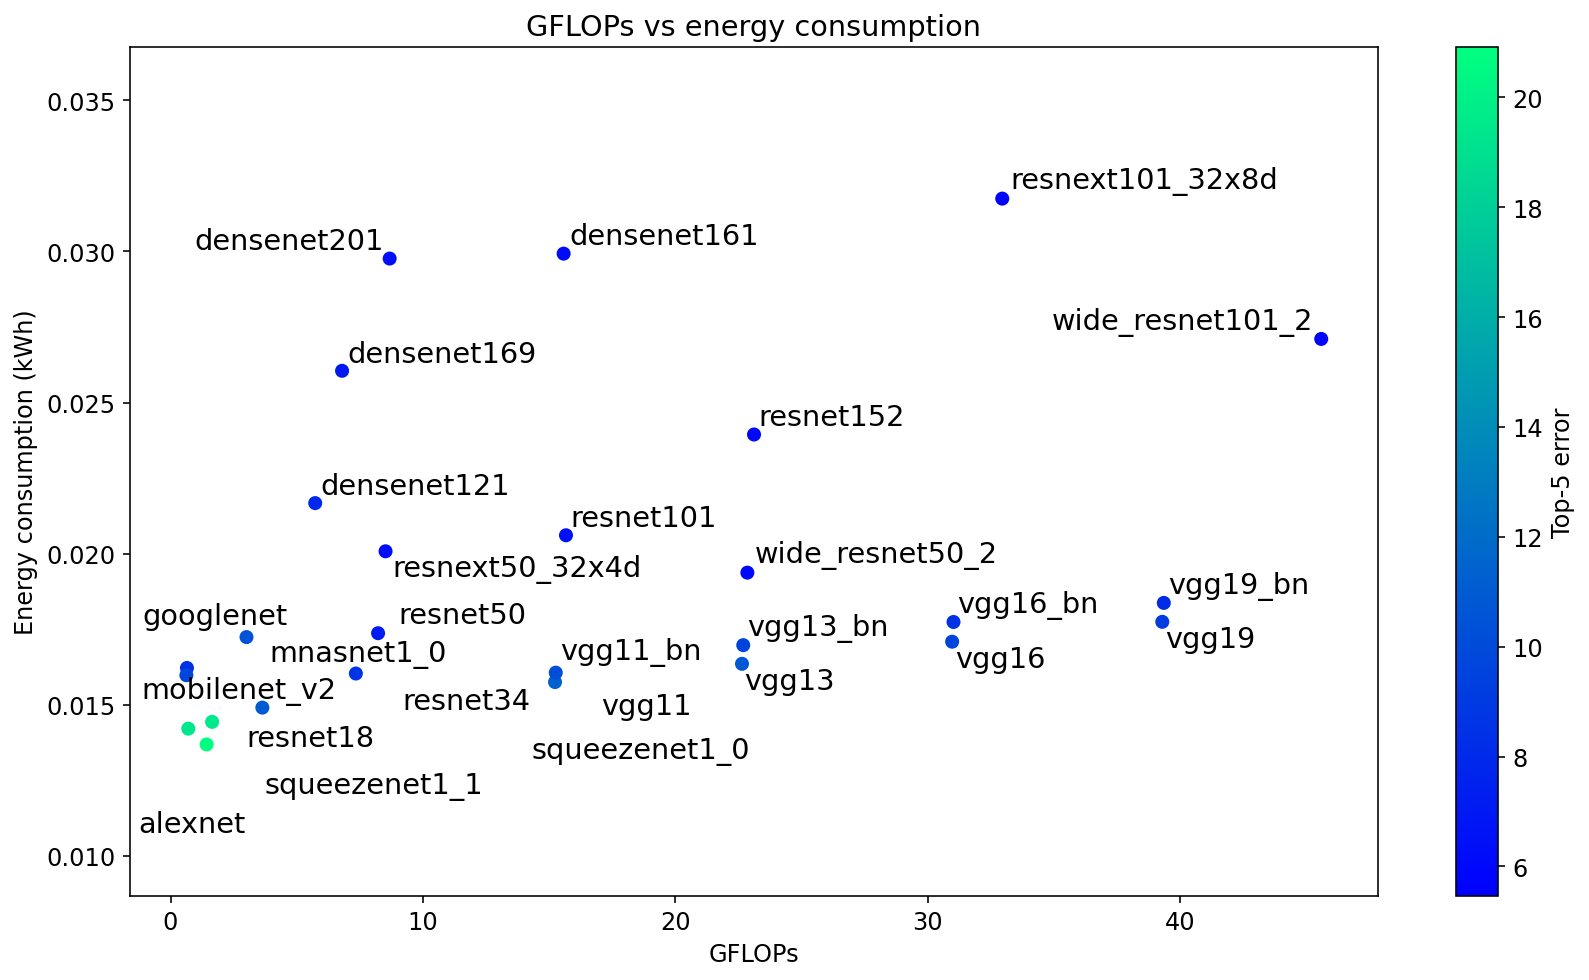

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
ax.set_xlabel("GFLOPs")
ax.set_ylabel("Energy consumption (kWh)")
ax.set_title("GFLOPs vs energy consumption")
cmap = cm.get_cmap('winter')
c = new_df['top5']
plt.ylim(min(new_df['empirical'])- 0.005,max(new_df['empirical'])+0.005)
plt.scatter(new_df['GFLOPS'], new_df['empirical'],
        c=c, cmap=cm.get_cmap('winter'))

texts = [ax.text(x, y, name,size='large') 
         for x, y, name in zip(new_df['GFLOPS'],new_df['empirical'],new_df['model'])]
cbar = plt.colorbar()
cbar.set_label('Top-5 error')
adjust_text(texts)
plt.tight_layout()
ax.figure.savefig('viz/inference_gflops_power.png',dpi=300)

## Run a linear regression

In [32]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(new_df['GFLOPS'],new_df['empirical'] )
print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
print('R squared ', r_value ** 2)
mse = metrics.mean_squared_error(new_df['GFLOPS'],new_df['empirical'])
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(new_df['GFLOPS'],new_df['empirical'])
print(f"rmse: {rmse} \nmae: {mae}")

slope 0.00012784470683773795 
intercept 0.01746605444245493
r_value 0.33389134269603626
p_value 0.08873727762143004
std_err 7.218390199222216e-05
R squared  0.11148342872736193
rmse: 20.70490034447861 
mae: 15.877661010166666


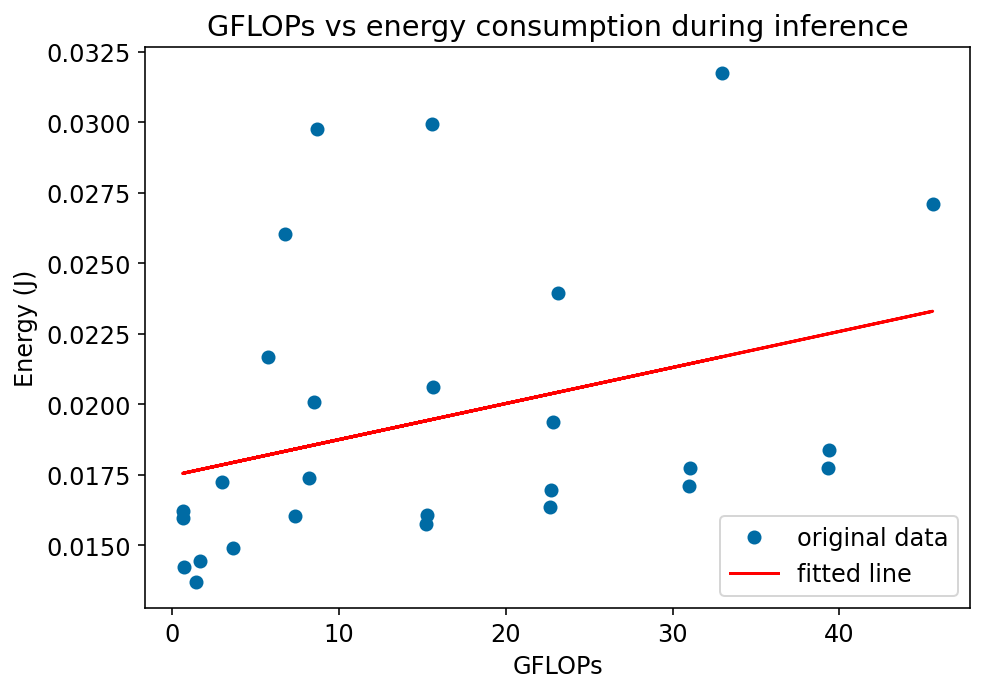

In [33]:
x = new_df['GFLOPS']
y = new_df['empirical']
plt.figure(figsize=(7,5))
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.xlabel("GFLOPs")
plt.ylabel("Energy (J)")
plt.title("GFLOPs vs energy consumption during inference")
plt.legend()
plt.tight_layout()
plt.savefig('viz/inference_gflops_power_fit.png',dpi=300)

## removing DenseNet model from the set 

In [34]:
df_minus_densenet = new_df[new_df['model'].str.match(r'(^densenet.*)') == False]
df_minus_densenet.model.count()

23

In [35]:
from scipy import stats
x = df_minus_densenet['GFLOPS']
y = df_minus_densenet['empirical'] 
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
print('R squared ', r_value ** 2)
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \nmae: {mae}")

slope 0.00017849236975227395 
intercept 0.015173951573279013
r_value 0.5987374614080724
p_value 0.002540286831316613
std_err 5.210464728881361e-05
R squared  0.35848654769338295
rmse: 22.047177127918804 
mae: 17.04438267873913


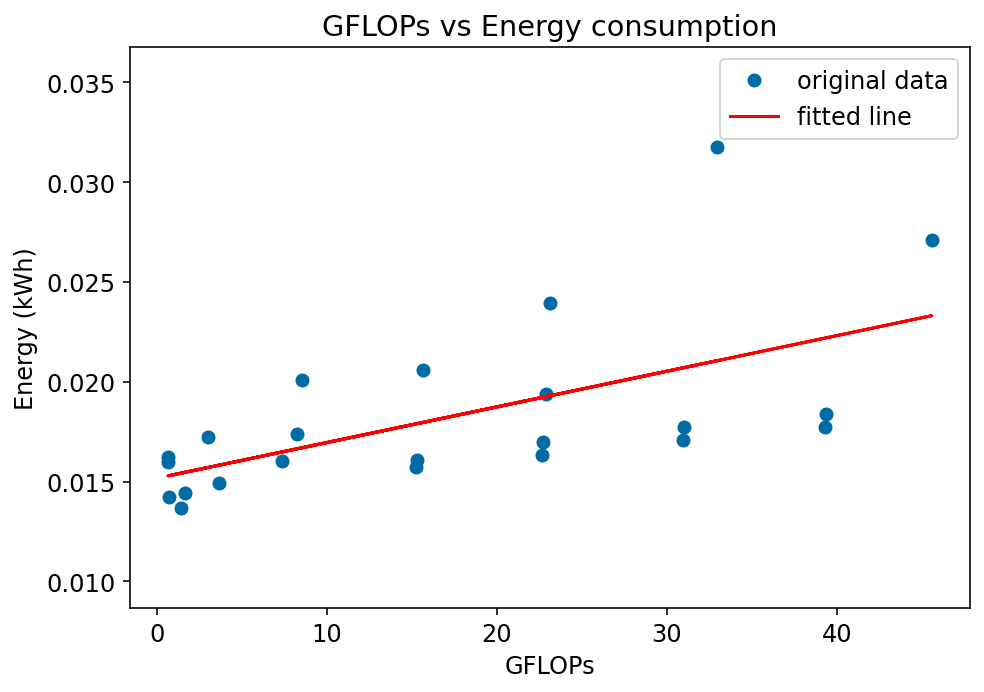

In [36]:
x = df_minus_densenet['GFLOPS']
y = df_minus_densenet['empirical']
plt.figure(figsize=(7,5))
plt.ylim(min(df_minus_densenet['empirical'])- 0.005,max(df_minus_densenet['empirical'])+0.005)
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.xlabel("GFLOPs")
plt.ylabel("Energy (kWh)")
plt.title("GFLOPs vs Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/inference_fit_minus_densenet.png',dpi=300)

## Testing within same architecture
Selected VGG for testing 

In [37]:
vgg_df = new_df.merge(vgg, on='model')

In [38]:
vgg_df.columns

Index(['model', 'start_time', 'end_time', 'start_seconds', 'end_seconds',
       'total_time', 's_date', 'e_date', 's_time', 'e_time', 'empirical',
       'macs_x', 'parameters_x', 'FLOPS_x', 'GFLOPS_x', 'TFLOPS_x',
       'Params(Million)_x', 'Log_x', 'GFLOPS_log_x',
       'Training 1 epoch(pfs-days)_x', 'top1_x', 'top5_x', 'macs_y',
       'parameters_y', 'FLOPS_y', 'GFLOPS_y', 'TFLOPS_y', 'Params(Million)_y',
       'Log_y', 'GFLOPS_log_y', 'Training 1 epoch(pfs-days)_y', 'top1_y',
       'top5_y'],
      dtype='object')

In [39]:
#ax = vgg_df.plot('GFLOPS', 'power', kind='scatter')
slope, intercept, r_value, p_value, std_err = stats.linregress(vgg_df['GFLOPS_y'],vgg_df['empirical'] )
print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
print('R squared ', r_value ** 2)
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \nmae: {mae}")

slope 8.931508368656112e-05 
intercept 0.014595761245340958
r_value 0.9421338851281736
p_value 0.00046362998785783743
std_err 1.297443054330012e-05
R squared  0.8876162575067067
rmse: 22.047177127918804 
mae: 17.04438267873913


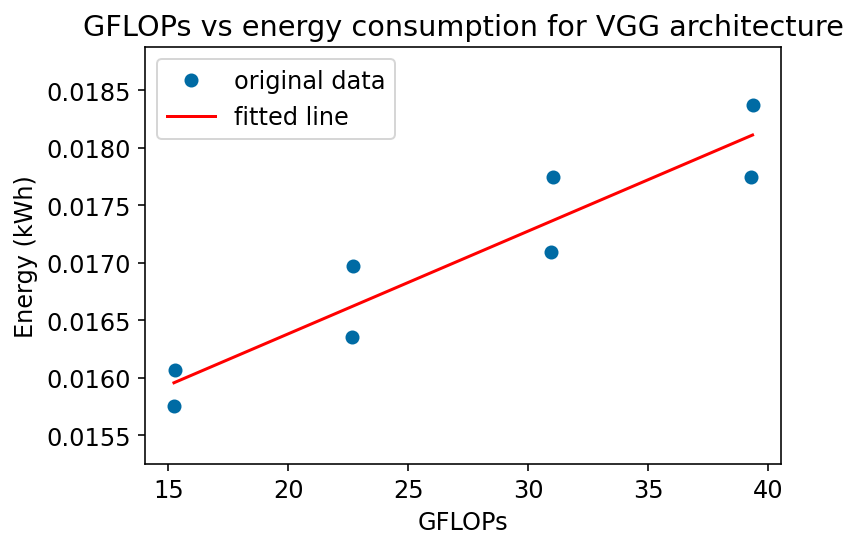

In [40]:
x = vgg_df['GFLOPS_y']
y = vgg_df['empirical']
plt.ylim(min(vgg_df['empirical'])- 0.0005,max(vgg_df['empirical'])+0.0005)
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.xlabel("GFLOPs")
plt.ylabel("Energy (kWh)")
plt.title("GFLOPs vs energy consumption for VGG architecture")
plt.legend()
plt.tight_layout()
plt.savefig('viz/vgg_gflops_power_fit.png',dpi=300)

## data for appendix

In [41]:
df_co2 = pd.read_csv("../BERT/results/co2data.csv")
uk_co2 = df_co2.loc[df_co2.country == 'United Kingdom'].impact.mean()

new_df['CO2e'] = uk_co2 * df_time_interval['empirical'] / (1000 * 3600)
new_df['kg CO2e'] = new_df['CO2e'] /1000

In [42]:
features = ['model','GFLOPS','empirical','kg CO2e','top1','top5']
cv_inference = new_df[features]
cv_inference.to_csv("results/cv_inference.csv", index=False)